<a href="https://www.kaggle.com/code/wagnersilva2/vis-o-computacional-com-fine-tunning?scriptVersionId=131047104" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>







'**INSTITUTO FEDERAL DE GOIÁS**

**PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA**

Disciplina: Visão Computacional

Professor: Alessandro Rodrigues e Silva

Alunos: 

In [1]:
!pip install livelossplot

In [2]:
# Imports do tensorflow e keras
import tensorflow as tf
from tensorflow import keras

# Imports utilizados na organização do dataset
import shutil
from collections import defaultdict
import json
from pathlib import Path
import os

# Imports utilizados no data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Imports utilizados para visualizar dados, imagem e gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras.utils as image

# Imports relacionados ao treinamento do modelo
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
#from livelossplot import PlotLossesKeras

#Import network
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Compatibilidade com a versão 1 do tensorflow: Habilita recursos do tensorboard
tf.compat.v1.disable_v2_behavior()

In [4]:
path = '/kaggle/input/dataset-ifg/'

In [5]:
# Carregando uma imagem do dataset de treino
img = tf.keras.utils.load_img(path+'train/anabele/anabele (10).jpg')

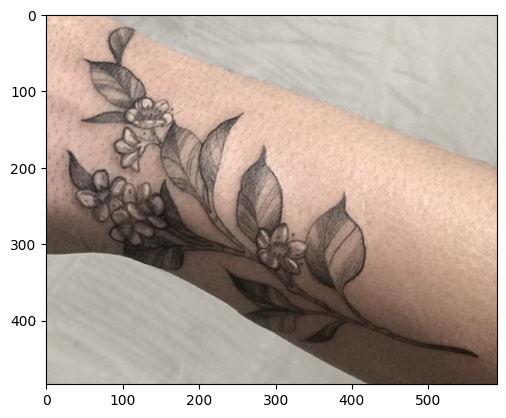

In [6]:
# Visualizando a imagem carregada
plt.imshow(img)

In [7]:
# Verificando as dimensões da imagem
cv2.imread(path+'train/anabele/anabele (10).jpg').shape

(484, 590, 3)

In [8]:
# Data augmentation
train_generator = ImageDataGenerator(
    rescale=1/255., 
    brightness_range=[0.1, 1.5],  # aumentar a variação do brilho
    rotation_range=180,  # aumentar a rotação
    horizontal_flip=True, 
    vertical_flip=True, 
    zoom_range=0.3,  # aumentar o zoom
    shear_range=0.3  # aumentar o shear
)

In [9]:
validation_generator = ImageDataGenerator(rescale=1/255.)

In [10]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [11]:
# Gerando um subconjunto de imagens
class_subset = ['anabele', 'chris','diniz','manuela','matheus','michel','pablo']
BATCH_SIZE=64

In [12]:
training = train_generator.flow_from_directory(path+'/train',
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               #subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validation = train_generator.flow_from_directory(path+'/valid',
                                               target_size=(128, 128),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               #subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 1323 images belonging to 7 classes.
Found 345 images belonging to 7 classes.


In [13]:
# Use a regularização L1_L2
from keras.regularizers import l1_l2

In [14]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)
    top_model = Dropout(0.5)(top_model)  # aumenta a taxa de dropout
    top_model = Dense(2048, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(top_model)  # adiciona outra camada densa
    top_model = Dropout(0.5)(top_model)  # aumenta a taxa de dropout
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)

    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
input_shape = (128, 128, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=7

n_steps = training.samples // BATCH_SIZE
n_val_steps = validation.samples // BATCH_SIZE
n_epochs = 100


In [16]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [17]:
# Reset our image data generators
training.reset()
validation.reset()
#testing.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=4)


/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


58889256/58889256 [==============================] - 1s 0us/step


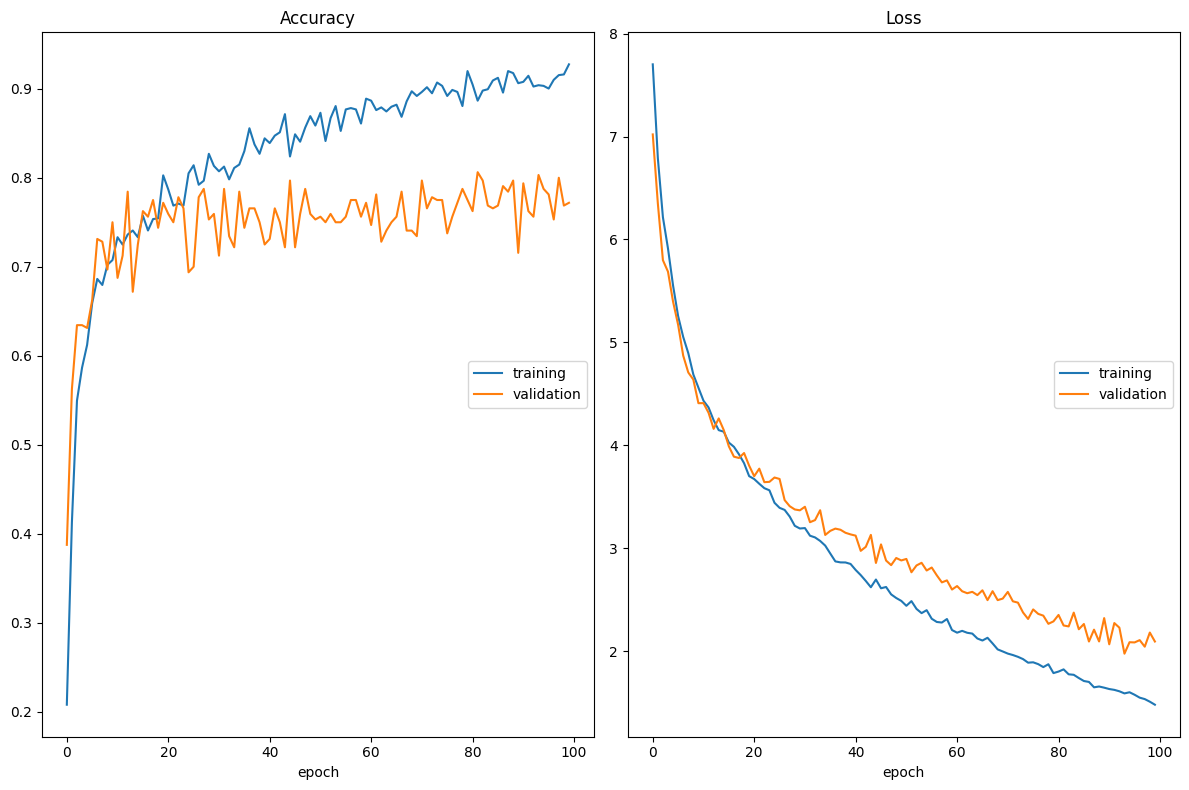

Accuracy
	training         	 (min:    0.208, max:    0.927, cur:    0.927)
	validation       	 (min:    0.387, max:    0.806, cur:    0.772)
Loss
	training         	 (min:    1.479, max:    7.701, cur:    1.479)
	validation       	 (min:    1.975, max:    7.020, cur:    2.093)
21/21 [==============================] - 15s 730ms/step - batch: 10.0000 - size: 63.0000 - loss: 1.4783 - acc: 0.9274 - val_loss: 2.0932 - val_acc: 0.7719


In [18]:
plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(training,
                                  epochs=n_epochs,
                                  validation_data=validation,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],  # adicionando o learning rate scheduler
                                  verbose=1)

In [19]:
from keras.models import load_model

scratch_model = load_model('/kaggle/input/pesos-cnn-zero/img_model.weights.best.hdf5')

scratch_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        36928     
                                                      

In [20]:
# Loading predictions from last article's model
from sklearn.metrics import accuracy_score

test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(path+'test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)
true_classes = testgen.classes
class_indices = training.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = scratch_model.predict(testgen)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

scratch_acc = accuracy_score(true_classes, scratch_pred_classes)
print("From Scratch Model Accuracy with Fine-Tuning: {:.2f}%".format(scratch_acc * 100))

Found 166 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-26 02:45:57.946714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_5/cond/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


From Scratch Model Accuracy with Fine-Tuning: 54.22%


In [21]:
# Generate predictions
vgg_model_ft.load_weights('/kaggle/working/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)
vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

/opt/conda/lib/python3.10/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


VGG16 Model Accuracy with Fine-Tuning: 80.12%


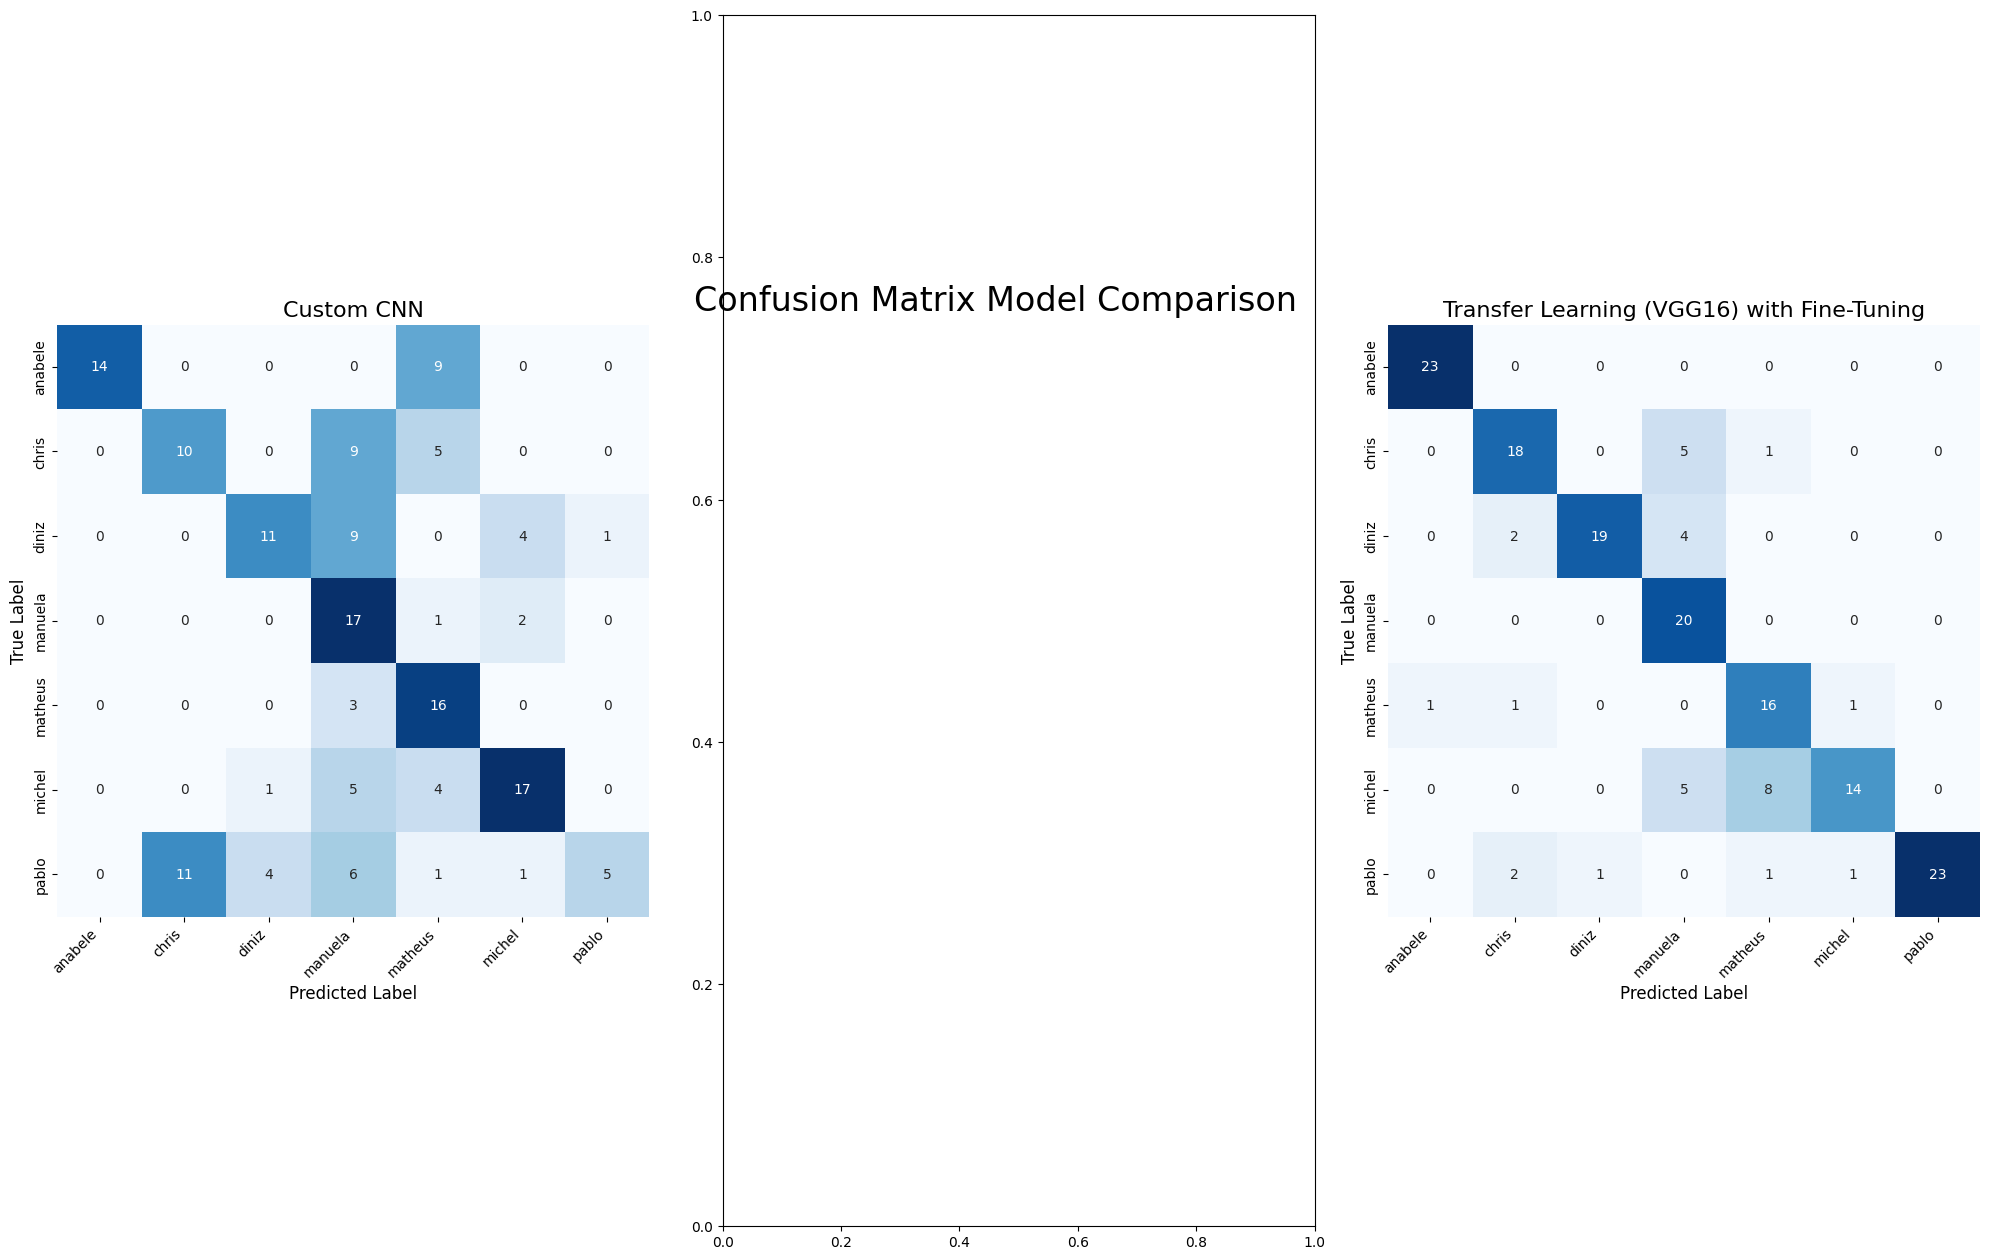

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names, ax1, title="Custom CNN")    
#plot_heatmap(true_classes, vgg_pred_classes, class_names, ax2, title="Transfer Learning (VGG16) No Fine-Tuning")    
plot_heatmap(true_classes, vgg_pred_classes_ft, class_names, ax3, title="Transfer Learning (VGG16) with Fine-Tuning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()